In [45]:
#Import some libraries that we need to run this code
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skopt.searchcv import BayesSearchCV
import shap
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import rc
import time
from pathlib import Path
from alibi.explainers import ALE, plot_ale



In [3]:
# ---------------------------------------
# --- Data Loading & Preprocessing ---
# ---------------------------------------

# 1. Load the raw dataset
DATA_PATH = 'Data_RC.xlsx'    # RC frame dataset
#DATA_PATH = 'Data_Steel.xlsx'  #Steel frame dataset
try:
    data = pd.read_excel(DATA_PATH)
    print(f"Loaded data: {data.shape[0]} rows, {data.shape[1]} columns")
except FileNotFoundError as e:
    raise FileNotFoundError(f"Cannot find data file at {DATA_PATH}") from e

# 2. Define feature and target columns
feature_cols = data.columns[:13].tolist()           # first 13 columns as features for RC dataset
#feature_cols = data.columns[1:15].tolist()           # first 15 columns as features for steel dataset
target_col   = data.columns[-1]                     # last column as response

# 3. Split into X (features) and y (target)
X = data[feature_cols]
y = data[target_col]

# 4. Train/test split (80/20) with reproducibility
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# 5. Initialize scalers
feature_scaler = StandardScaler()
target_scaler  = MinMaxScaler()

# 6. Fit on training set, transform both train & test
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled  = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(
    y_train.to_numpy().reshape(-1, 1)
).ravel()
y_test_scaled  = target_scaler.transform(
    y_test.to_numpy().reshape(-1, 1)
).ravel()

# 7. (Optional) Inspect shapes
print(f"X_train_scaled: {X_train_scaled.shape}, y_train_scaled: {y_train_scaled.shape}")


Loaded data: 720 rows, 14 columns
X_train_scaled: (576, 13), y_train_scaled: (576,)


In [7]:
# ---------------------------------------
# --- training and tuning ML model ---
# ---------------------------------------
# 1. Constants & Data Properties
RANDOM_STATE = 42
n_features   = X_train_scaled.shape[1]  # number of input features

# 2. Timer Start
start_time = time.time()

# 3. Pipeline Definition
#    - SelectKBest: choose top-k features via univariate F-test
#    - SVR: Support Vector Regression model
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('svm', SVR())
])

# 4. Bayesian Optimization Search Space
bayes_space = {
    'feature_selection__k': (5, n_features),              # k from 5 to all features
    'svm__C': (1e-3, 1e3, 'log-uniform'),                 # regularization parameter
    'svm__gamma': (1e-4, 1e1, 'log-uniform'),             # RBF kernel width
    'svm__epsilon': (1e-3, 1.0, 'uniform')                # epsilon-insensitive loss
}

# 5. Run Bayesian Optimization
bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=bayes_space,
    n_iter=30,
    cv=5,
    scoring='r2',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
bayes_search.fit(X_train_scaled, y_train_scaled)

# 6. Capture Best Parameters from Bayesian Search
best_params = bayes_search.best_params_

# 7. Define Refined Grid Around Bayesian Results
grid_space = {
    'feature_selection__k': [
        3, 5, 8, 10, best_params['feature_selection__k']
    ],
    'svm__C': [
        0.01, 0.1, 1, 10, 100, best_params['svm__C']
    ],
    'svm__gamma': [
        'scale', 'auto', 0.001, 0.01, 0.1, best_params['svm__gamma']
    ],
    'svm__epsilon': [
        0.001, 0.01, 0.1, 0.5, best_params['svm__epsilon']
    ]
}

# 8. Run Exhaustive Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=grid_space,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train_scaled)

# 9. Retrieve Best Model & Report Timing
best_model = grid_search.best_estimator_
print(f"Optimal hyperparameters: {grid_search.best_params_}")
print(f"Tuning completed in {(time.time() - start_time):.2f} seconds")

Optimal hyperparameters: {'feature_selection__k': 13, 'svm__C': 10, 'svm__epsilon': 0.01, 'svm__gamma': 0.01}
Tuning completed in 35.62 seconds


In [11]:
# ---------------------------------------
# --- Model prediction and evaluation ---
# ---------------------------------------


# 1. Generate scaled predictions
y_train_pred_scaled = best_model.predict(X_train_scaled)
y_test_pred_scaled  = best_model.predict(X_test_scaled)

# 2. Inverse-transform to original scale with target_scaler
y_train_pred = target_scaler.inverse_transform(
    y_train_pred_scaled.reshape(-1, 1)
).ravel()
y_test_pred = target_scaler.inverse_transform(
    y_test_pred_scaled.reshape(-1, 1)
).ravel()

# 3. True (unscaled) targets
y_train_true = y_train.to_numpy().ravel()
y_test_true  = y_test.to_numpy().ravel()

# 4. Adjusted R² helper
def adjusted_r2(y_true, y_pred, n_features):
    """Compute adjusted R² given true/pred and number of features."""
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

n_features = X_train_scaled.shape[1]

# 5. Core metrics
mse_train = mean_squared_error(y_train_true, y_train_pred)
mse_test  = mean_squared_error(y_test_true,  y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test  = np.sqrt(mse_test)
mae_train = mean_absolute_error(y_train_true, y_train_pred)
mae_test  = mean_absolute_error(y_test_true,  y_test_pred)
r2_train  = r2_score(y_train_true, y_train_pred)
r2_test   = r2_score(y_test_true,  y_test_pred)
adj_r2_train = adjusted_r2(y_train_true, y_train_pred, n_features)
adj_r2_test  = adjusted_r2(y_test_true,  y_test_pred,  n_features)

# 6. Normalized metrics
train_mean = np.mean(y_train_true)
train_var  = np.var(y_train_true)
test_mean  = np.mean(y_test_true)
test_var   = np.var(y_test_true)

nmse_train = mse_train / train_var
nmse_test  = mse_test  / test_var
nrmse_train = rmse_train / train_mean
nrmse_test  = rmse_test  / test_mean
nmae_train  = mae_train  / train_mean
nmae_test   = mae_test   / test_mean
mape_train = np.mean(np.abs((y_train_true - y_train_pred) / y_train_true)) * 100
mape_test  = np.mean(np.abs((y_test_true  - y_test_pred ) / y_test_true))  * 100

# 7. Aggregate into DataFrame
metrics = {
    'MSE': [mse_train, mse_test],
    'RMSE': [rmse_train, rmse_test],
    'MAE': [mae_train, mae_test],
    'R2': [r2_train, r2_test],
    'Adj_R2': [adj_r2_train, adj_r2_test],
    'NMSE': [nmse_train, nmse_test],
    'NRMSE': [nrmse_train, nrmse_test],
    'NMAE': [nmae_train, nmae_test],
    'MAPE (%)': [mape_train, mape_test],
}

metrics_df = pd.DataFrame(metrics, index=['Train', 'Test'])

# 8. Display
print("Model Performance Metrics:")
print(metrics_df)


Model Performance Metrics:
                 MSE        RMSE         MAE        R2    Adj_R2      NMSE  \
Train   48197.846068  219.540079  111.441299  0.966844  0.966077  0.033156   
Test   137905.687764  371.356551  177.392522  0.912425  0.903667  0.087575   

          NRMSE      NMAE  MAPE (%)  
Train  0.116781  0.059280  6.529062  
Test   0.192896  0.092144  9.477440  


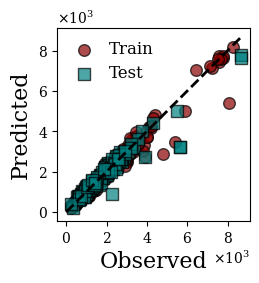

In [23]:
# ---------------------------------------
# --- Plot model performance ---
# ---------------------------------------

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator, ScalarFormatter

# Assumes y_train_true, y_train_pred, y_test_true, y_test_pred are defined

fig, ax = plt.subplots(figsize=(2.5, 2.5))
rc('font', family='serif')

# Scatter
ax.scatter(y_train_true, y_train_pred,
           label='Train', s=70, marker='o',
           edgecolor='k', alpha=0.7, color='darkred')
ax.scatter(y_test_true, y_test_pred,
           label='Test',  s=70, marker='s',
           edgecolor='k', alpha=0.7, color='teal')

# Parity line
max_val = max(y_train_true.max(), y_test_true.max())
ax.plot([0, max_val], [0, max_val], '--k', lw=2)

# Labels
ax.set_xlabel(r'Observed', fontsize=16)
ax.set_ylabel(r'Predicted', fontsize=16)

# Legend
leg = ax.legend(frameon=False)
for txt in leg.get_texts():
    txt.set_fontsize(12)

# Auto-locate up to 5 “nice” ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Use scientific notation
sf = ScalarFormatter(useMathText=True)
sf.set_powerlimits((0,0))
ax.xaxis.set_major_formatter(sf)
ax.yaxis.set_major_formatter(sf)
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# Equal aspect
ax.set_aspect('equal', adjustable='box')

# Save & show
fig.savefig('PredVsObs_option1.pdf', dpi=1800, bbox_inches='tight')
plt.show()



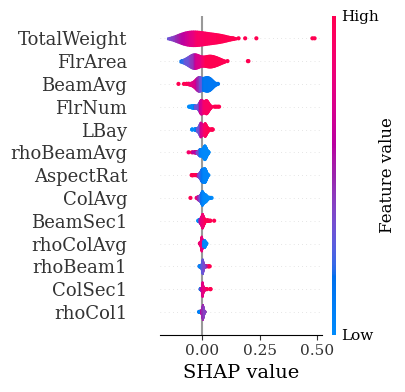

In [37]:
# ---------------------------------------
# --- Shapely plots  ---
# ---------------------------------------
#this is to allow displaying widget
shap.initjs()
#getting name of features
feature_names = X_test.columns.tolist()
#saving the figure based on the dataset name
dataset_name = Path(DATA_PATH).stem 

# Parameters
K = 50               # Number of k-means centers to summarize the background
RANDOM_STATE = 42    # Seed for reproducibility


# 1. Create a small background dataset via k-means
background = shap.kmeans(X_test_scaled, K)

# 2. Initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(
    best_model.predict,
    background,
    link="identity"
)

# 3. Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)



# 4. Create the plot (no ax= kw)
rc('font', family='serif')
shap.summary_plot(
    shap_values,
    X_test,                    # pass DataFrame so column names are used
    plot_type="violin",
    show=False
)

fig = plt.gcf()
ax  = plt.gca()

w, h = fig.get_size_inches()
fig.set_size_inches(w * 0.5, h * 0.6)
ax.set_xlabel("SHAP value", fontsize=14)

# 5. Tidy layout and save
plt.tight_layout()
output_pdf = f"SHAP_SVM_{dataset_name}.pdf"
fig.savefig(output_pdf, dpi=1800, bbox_inches='tight')
plt.show()

In [77]:
# ----------------------------------------------------------------------
# --- Optimization for an example 5-story building from RC dataset----
# ----------------------------------------------------------------------
start_time = time.time()
import numpy as np
import pandas as pd
from deap import base, creator, tools

# Initialize a dictionary to store unscaled beam values for the best individual at each generation
best_beam_values = {"Generation": [], "BeamAvg": [], "BeamSec1": [], "rhoBeamAvg":  [], "rhoBeam1":  [] }
best_col_values = {"Generation": [], "ColAvg": [], "ColSec1": [], "rhoColAvg": [], "rhoCol1": []}


# Evaluation function
def evaluate(individual):
    """
    Evaluate an individual's fitness based on a predefined model.
    """
    X_individual = pd.DataFrame([individual], columns=[
        'TotalWeight', 'BeamAvg', 'ColAvg', 'ColSec1', 'BeamSec1', 
        'rhoColAvg', 'rhoBeamAvg', 'rhoCol1', 'rhoBeam1'
    ])
    X_individual = X_individual.assign(FlrNum=5, LBay=30, AspectRat=1, FlrArea=22500)
    X_individual = X_individual[[
     'FlrNum', 'LBay', 'FlrArea', 'AspectRat', 'TotalWeight', 'BeamAvg',
 'ColAvg', 'ColSec1', 'BeamSec1', 'rhoColAvg', 'rhoBeamAvg', 'rhoCol1', 'rhoBeam1'    ]]
    X_individual_scaled = feature_scaler.transform(X_individual)
    y_pred_scaled = best_model.predict(X_individual_scaled)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    
   
    return y_pred[0],

# Create the fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Define the toolbox
toolbox = base.Toolbox()

# Custom gene generator for the 10 genes with specific ranges
def custom_gene_generator():
    """
    Generate a random individual with predefined ranges for each gene.
    """
    

    
    gene_ranges = {
        'TotalWeight': (X['TotalWeight'].min(), X['TotalWeight'].max()),      # Example range for W_total
        'BeamAvg': (X['BeamAvg'].min(), X['BeamAvg'].max()),      # Example range for I_int_avg
        'ColAvg': (X['ColAvg'].min(), X['ColAvg'].max()),      # Example range for I_int_max
        'ColSec1': (X['ColSec1'].min(), X['ColSec1'].max()),        # Example range for I_int_min
        'BeamSec1': (X['BeamSec1'].min(), X['BeamSec1'].max()),     # Example range for I_beam_avg
        'rhoColAvg': (X['rhoColAvg'].min(), X['rhoColAvg'].max()),     # Example range for I_beam_max
        'rhoBeamAvg': (X['rhoBeamAvg'].min(), X['rhoBeamAvg'].max()),     # Example range for I_beam_min
        'rhoCol1': (X['rhoCol1'].min(), X['rhoCol1'].max()),      # Example range for I_ext_avg
        'rhoBeam1': (X['rhoBeam1'].min(), X['rhoBeam1'].max()),      # Example range for I_ext_max

    }
    return [np.random.uniform(low, high) for low, high in gene_ranges.values()]

# Register the custom gene generator and genetic algorithm operators
toolbox.register("attr_genes", custom_gene_generator)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_genes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Set up genetic algorithm parameters
population = toolbox.population(n=100)
n_generations = 100
elite_fraction = 0.1
initial_mutation_prob = 0.4
best_fitness_progress = []

# Enhanced GA loop with elite selection, adaptive mutation, and logging of unscaled beam values
for gen in range(n_generations):
    elite_size = int(len(population) * elite_fraction)
    elite = tools.selBest(population, elite_size)

    # Select and clone the offspring
    offspring = toolbox.select(population, len(population) - elite_size)
    offspring = list(map(toolbox.clone, offspring))

    # Crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if np.random.rand() < 0.7:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Adaptive mutation rate
    mutation_prob = max(0.1, initial_mutation_prob - (gen / n_generations) * initial_mutation_prob)
    for mutant in offspring:
        if np.random.rand() < mutation_prob:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate invalid individuals
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Combine elite individuals with offspring for the next generation
    population[:] = elite + offspring

    # Track the best fitness and unscaled beam values in the current generation
    best_individual = tools.selBest(population, 1)[0]
    best_fitness = best_individual.fitness.values[0]
    best_fitness_progress.append(best_fitness)

    # Log unscaled `I_beam` values for the best individual
    X_best = pd.DataFrame([best_individual], columns=[
        'TotalWeight', 'BeamAvg', 'ColAvg', 'ColSec1', 'BeamSec1', 
        'rhoColAvg', 'rhoBeamAvg', 'rhoCol1', 'rhoBeam1'
    ])
    best_beam_values["Generation"].append(gen)
    best_beam_values["BeamAvg"].append(X_best.iloc[0]["BeamAvg"])
    best_beam_values["BeamSec1"].append(X_best.iloc[0]["BeamSec1"])
    best_beam_values["rhoBeamAvg"].append(X_best.iloc[0]["rhoBeamAvg"])
    best_beam_values["rhoBeam1"].append(X_best.iloc[0]["rhoBeam1"])
   
    best_col_values["Generation"].append(gen)
    best_col_values["ColAvg"].append(X_best.iloc[0]["ColAvg"])
    best_col_values["ColSec1"].append(X_best.iloc[0]["ColSec1"])
    best_col_values["rhoColAvg"].append(X_best.iloc[0]["rhoColAvg"])
    best_col_values["rhoCol1"].append(X_best.iloc[0]["rhoCol1"])

    

    # Optional: Early stopping if no improvement for several generations
    if gen > 5 and all(best_fitness == bf for bf in best_fitness_progress[-5:]):
        print(f"Early stopping at generation {gen}")
        break

# Save the unscaled beam values for all generations to a DataFrame
best_beam_values_df = pd.DataFrame(best_beam_values)
print(best_beam_values_df)

# Get the best individual
best_individual = tools.selBest(population, 1)[0]
print(f"Best Individual: {best_individual}")
print(f"Best Response Value: {evaluate(best_individual)[0]}")
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

/opt/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


    Generation      BeamAvg    BeamSec1  rhoBeamAvg  rhoBeam1
0            0   720.775906  222.745808    0.884767  2.299028
1            1  1185.300013  799.942832    1.320967  1.445635
2            2   706.650852  599.419558    1.139306  1.577024
3            3   706.650852  599.419558    1.139306  1.577024
4            4   706.650852  599.419558    1.139306  1.577024
..         ...          ...         ...         ...       ...
95          95   695.823902  793.832230    1.514903  0.598521
96          96   695.823902  793.832230    1.514903  0.598521
97          97   695.775267  793.897692    1.514525  0.598124
98          98   695.718679  793.896231    1.514440  0.598853
99          99   695.788196  793.885608    1.514467  0.598261

[100 rows x 5 columns]
Best Individual: [-73587195.20864406, 695.7881957748093, 518.8141805238715, 967.51202494473, 793.8856084855536, 1.3097185852656015, 1.514466683570211, -0.532377579373586, 0.5982607068294903]
Best Response Value: -1606.2117862010339


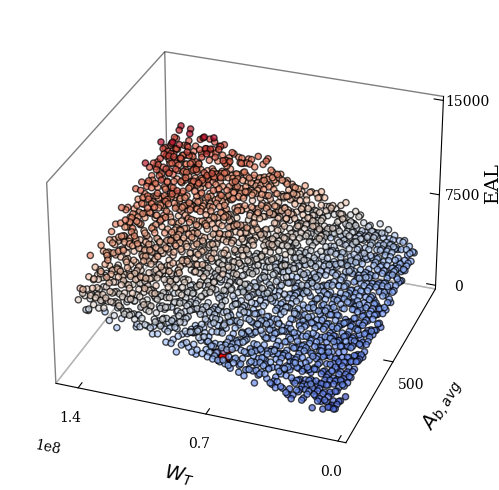

In [83]:
# ----------------------------------------------------------------------
# --- Optimization for an example 5-story building from RC dataset----
# ----------------------------------------------------------------------

# Generate 3D plot for W_total and I_int_avg with response on vertical axis
W_total_range = np.linspace(X['TotalWeight'].min(), X['TotalWeight'].max(), 50)
BeamAvg_range = np.linspace(X['BeamAvg'].min(), X['BeamAvg'].max(), 50)

W_total_grid, BeamAvg_grid = np.meshgrid(W_total_range, BeamAvg_range)

# Create a DataFrame to hold constant values and varying W_total, I_int_avg
X_grid = pd.DataFrame({
    'TotalWeight': W_total_grid.ravel(),
    'BeamAvg': BeamAvg_grid.ravel(),
    'FlrNum':5,
    'AspectRat':1,
    'LBay': 30,
    'FlrArea': 22500
})

# Add remaining features with their mean values from the original dataset
for col in X.columns:
    if col not in ['TotalWeight', 'BeamAvg', 'FlrNum', 'LBay', 'AspectRat', 'FlrArea']:
        X_grid[col] = np.random.choice(X[col].values, size=len(X_grid))

# Sort the columns of X_grid as requested
X_grid = X_grid[[ 'FlrNum', 'LBay', 'FlrArea', 'AspectRat', 'TotalWeight', 'BeamAvg',
 'ColAvg', 'ColSec1', 'BeamSec1', 'rhoColAvg', 'rhoBeamAvg', 'rhoCol1', 'rhoBeam1'  ]]

        
# Scale the feature set
X_grid_scaled = feature_scaler.transform(X_grid)

# Predict response for the grid
y_grid_scaled = best_model.predict(X_grid_scaled)
y_grid = target_scaler.inverse_transform(y_grid_scaled.reshape(-1, 1)).ravel()

# Reshape predictions to match the grid shape
y_grid = y_grid.reshape(W_total_grid.shape)


# Create a 3D scatter plot for W_total, I_beam_min, and response

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(111, projection='3d')
rc('font',family='serif')
# Scatter plot of the original data
ax.scatter(X_grid['TotalWeight'], X_grid['BeamAvg'], y_grid, c=y_grid, cmap='coolwarm', alpha=0.7, edgecolor='k')

# Label axes
ax.set_xlabel('$W_{T}$', fontsize=14, labelpad=10)
ax.set_ylabel('$A_{b,avg}$', fontsize=14, labelpad=10)
ax.set_zlabel('EAL', fontsize=14, rotation=90, labelpad=5)



# Beautify the plot
#ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis._axinfo['tick']['inward_factor'] = 0
ax.xaxis._axinfo['tick']['outward_factor'] = 0.4
ax.yaxis._axinfo['tick']['inward_factor'] = 0
ax.yaxis._axinfo['tick']['outward_factor'] = 0.4
ax.zaxis._axinfo['tick']['inward_fabctor'] = 0
ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
ax.zaxis._axinfo['tick']['outward_factor'] = 0.4

ax.xaxis.set_ticks([0,7e7,14e7])
ax.yaxis.set_ticks([0,0.5e3,1e3])
ax.zaxis.set_ticks([0,0.75e4,1.5e4])
ax.set_zlim([0,1.5e4])
# Plot the best individual
best_individual_df = pd.DataFrame([best_individual], columns=[ 'TotalWeight', 'BeamAvg', 'ColAvg', 'ColSec1', 'BeamSec1', 
        'rhoColAvg', 'rhoBeamAvg', 'rhoCol1', 'rhoBeam1'])
ax.scatter(-best_individual_df['TotalWeight'], best_individual_df['BeamAvg'], -evaluate(best_individual)[0],marker='*', color='r', s=300, edgecolor='k')

# Add legend
ax.view_init(30, 110)
plt.tight_layout()
plt.savefig('OptPlot_RC.pdf',format='pdf', dpi=1800)
plt.show()
